# PSET 3

LINK: https://github.com/benjaminzaidel/MSE228New/blob/master/PSET3_228.ipynb

## Question 1

Consider the de-sparsified Lasso process and the double selection process (described in Section 4.4 of the textbook), which are alternative processes to the double Lasso; in that they are also Neyman orthogonal processes that allow for valid inference in high-dimensional data.


### a

Show that the de-sprasified lasso satisfies the Neyman orthogonality property


To show that the de-sparsified Lasso satisfies the Neyman orthogonality property, we consider the key moment condition involved in the estimation process:

$[
M(a, \eta) = E[(Y - aD - b'W)\tilde{D}(\gamma)] = 0
]$

where:
- $( \eta = (b', \gamma')' )$ represents the nuisance parameters,
- $( \tilde{D}(\gamma) = D - \gamma'W )$ represents the residual from regressing  D onto  W ,
- $( \gamma )$ is the best linear predictor coefficient obtained from regressing  D  on  W.

The estimator $ \alpha(\eta) $ is defined as:

$[
\alpha(\eta) = \left(E[D\tilde{D}(\gamma)]\right)^{-1} E[(Y - b'W)\tilde{D}(\gamma)]
]$

For Neyman orthogonality to hold, the moment condition must be insensitive to small perturbations in the nuisance parameters around their true values $ (\eta_0) $. Mathematically, this is expressed as:

$[
\frac{\partial}{\partial \eta} \alpha(\eta) \bigg|_{\eta = \eta_0} = 0
]$

or equivalently:

$[
\frac{\partial}{\partial \eta} M(\alpha(\eta_0), \eta_0) = 0
]$

This implies that the score function is orthogonal to the nuisance parameters at their true values. Since $ (\alpha(\eta) )$ satisfies this condition, the de-sparsified Lasso estimator is Neyman orthogonal.

This orthogonality ensures that the estimator is robust to small errors in the estimation of nuisance parameters, which is critical for valid inference in high-dimensional settings.


### b



#### **1. Scaled Difference Approximation**

We start by approximating the scaled difference:

$$
\sqrt{n}(\hat{a} - a) \approx \frac{\sqrt{n} \, \mathbb{E}_n[(Y - aD - \beta'W) \tilde{D}]}{\mathbb{E}_n[\tilde{D}D]} = \frac{\sqrt{n} \, \mathbb{E}_n[\tilde{e} \tilde{D}]}{\mathbb{E}_n[\tilde{D}D]}
$$

Where:
- $( Y )$ = outcome variable  
- $( D )$ = treatment variable  
- $( W )$ = control covariates  
- $( \beta )$ = coefficients for $( W )$  
- $( \tilde{D} )$ = residual from regressing $( D )$ on $( W )$ (orthogonalized $( D )$)  
- $( \tilde{e} )$ = residual error term  

---

#### **2. Law of Large Numbers (LLN)**

The denominator $( \mathbb{E}_n[\tilde{D}D] )$ converges to its population expectation as $( n \to \infty )$.

---

#### **3. Applying the Central Limit Theorem (CLT)**

For the numerator:

$$
\sqrt{n} \, \mathbb{E}_n[\tilde{e} \tilde{D}] \xrightarrow{d} N\left(0, \sigma^2 \mathbb{E}[\tilde{D}^2]\right)
$$

Where $( \sigma^2 )$ represents the variance of the residuals.

---

#### **4. Asymptotic Variance Formula**

$$
\text{Var}(\hat{a}) \approx \frac{\sigma^2 \, \mathbb{E}[\tilde{D}^2]}{\left(\mathbb{E}[\tilde{D}D]\right)^2}
$$

---

#### **5. Standard Error Formula**

$$
\text{SE}(\hat{a}) \approx \frac{\sqrt{\sigma^2 \, \mathbb{E}[\tilde{D}^2]}}{\mathbb{E}[\tilde{D}D]}
$$

### c

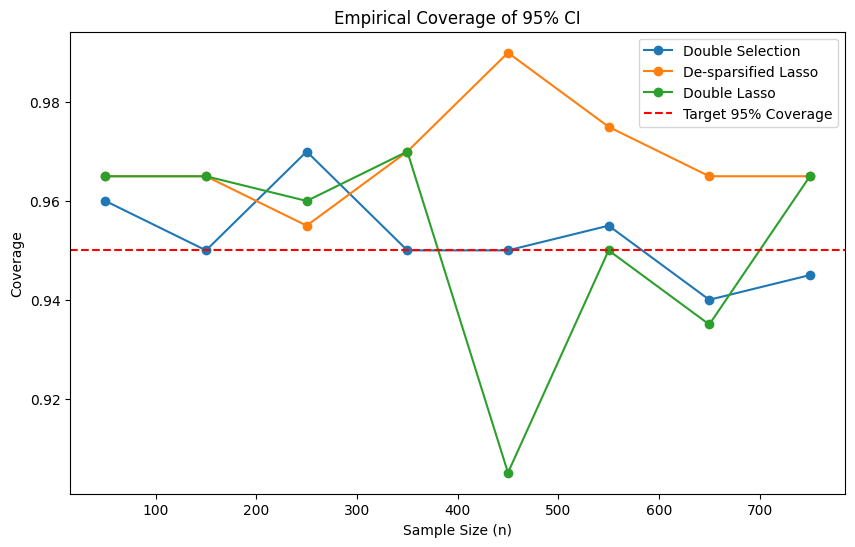

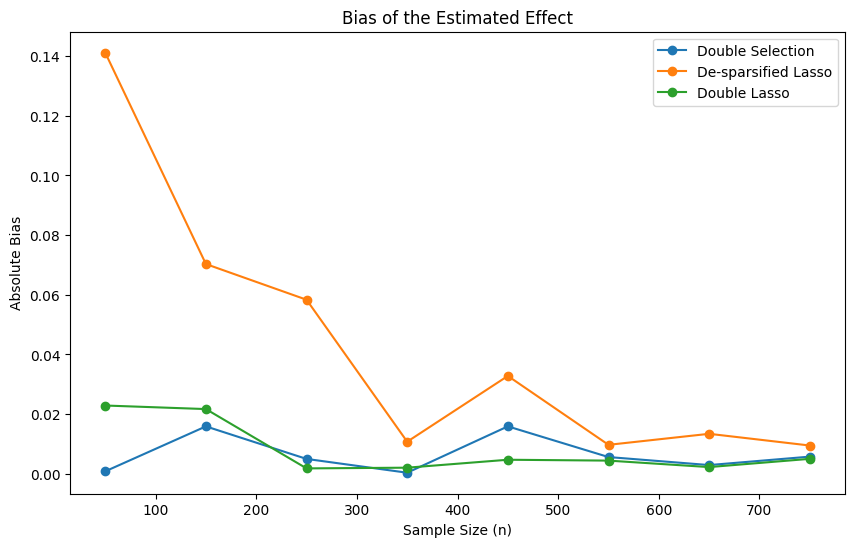

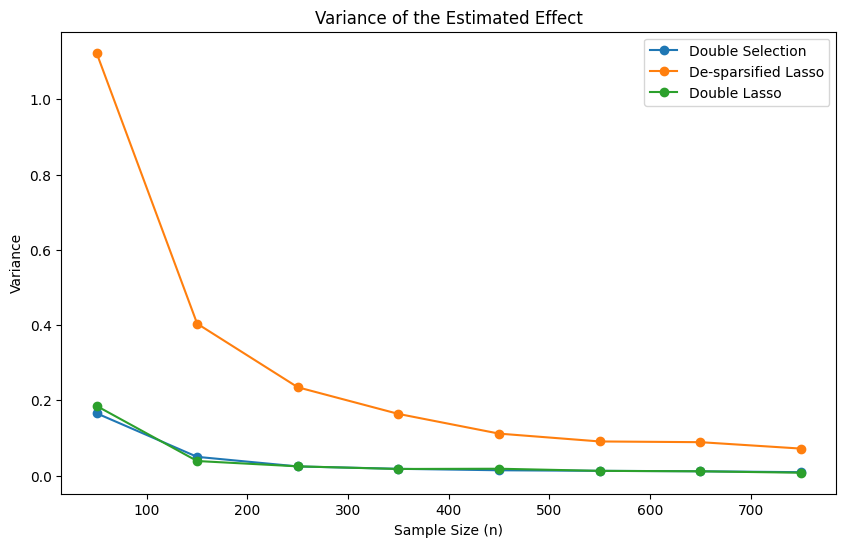

In [19]:
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Data Generation Function

def gen_data(n, d, p, delta, base):
    X = np.random.randn(n, d)
    D = np.random.binomial(1, p, size=n)
    beta = np.random.randn(d)
    y = base + delta * D + X.dot(beta) + np.random.randn(n)
    return y, D, X


# Estimation Procedures

def double_selection(y, D, X):

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Lasso on outcome equation:
    lasso_y = LassoCV(cv=5).fit(X_std, y)
    selected_y = np.where(lasso_y.coef_ != 0)[0]
    
    # Lasso on treatment equation:
    lasso_D = LassoCV(cv=5).fit(X_std, D)
    selected_D = np.where(lasso_D.coef_ != 0)[0]
    
    # Union of selected variables:
    selected = np.union1d(selected_y, selected_D)
    
    if selected.size > 0:
        X_sel = X_std[:, selected]
        X_final = np.column_stack((D, X_sel))
    else:
        X_final = D.reshape(-1,1)
    
    model = sm.OLS(y, sm.add_constant(X_final)).fit(cov_type='HC3')
    tau_hat = model.params[1]  # coefficient on D
    se = model.bse[1]
    return tau_hat, se

def de_sparsified_lasso(y, D, X):

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    lasso_D = LassoCV(cv=5).fit(X_std, D)
    D_hat = lasso_D.predict(X_std)
    D_resid = D - D_hat
    
    model = sm.OLS(y, sm.add_constant(D_resid)).fit()
    tau_hat = model.params[1]
    se = model.bse[1]
    return tau_hat, se

def double_lasso(y, D, X):

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    lasso_y = LassoCV(cv=5).fit(X_std, y)
    selected = np.where(lasso_y.coef_ != 0)[0]
    
    if selected.size > 0:
        X_sel = X_std[:, selected]
        X_final = np.column_stack((D, X_sel))
    else:
        X_final = D.reshape(-1, 1)
    
    model = sm.OLS(y, sm.add_constant(X_final)).fit(cov_type='HC3')
    tau_hat = model.params[1]
    se = model.bse[1]
    return tau_hat, se


# Simulation Experiment Routine
def simulation_experiment(method_func, trials, n_grid, d, p, delta, base):

    coverage_list = []
    bias_list = []
    variance_list = []
    
    for n in n_grid:
        estimates = []
        coverage_count = 0
        for i in range(trials):
            y, D, X = gen_data(n, d, p, delta, base)
            tau_hat, se = method_func(y, D, X)
            estimates.append(tau_hat)
            ci_lower = tau_hat - 1.96 * se
            ci_upper = tau_hat + 1.96 * se
            if ci_lower <= delta <= ci_upper:
                coverage_count += 1
        coverage = coverage_count / trials
        bias = np.abs(np.mean(estimates) - delta)
        variance = np.var(estimates)
        coverage_list.append(coverage)
        bias_list.append(bias)
        variance_list.append(variance)
    return coverage_list, bias_list, variance_list

# Main Simulation Settings

n_grid = [50, 150, 250, 350, 450, 550, 650, 750]
trials = 200
d = 10
p = 0.2
delta = 1.0
base = 0.3

# Run simulation for each method:
coverage_ds, bias_ds, var_ds = simulation_experiment(double_selection, trials, n_grid, d, p, delta, base)
coverage_ds_lasso, bias_ds_lasso, var_ds_lasso = simulation_experiment(de_sparsified_lasso, trials, n_grid, d, p, delta, base)
coverage_dl, bias_dl, var_dl = simulation_experiment(double_lasso, trials, n_grid, d, p, delta, base)

# Plotting the Results
plt.figure(figsize=(10,6))
plt.plot(n_grid, coverage_ds, marker='o', label='Double Selection')
plt.plot(n_grid, coverage_ds_lasso, marker='o', label='De-sparsified Lasso')
plt.plot(n_grid, coverage_dl, marker='o', label='Double Lasso')
plt.axhline(0.95, color='red', linestyle='--', label='Target 95% Coverage')
plt.xlabel('Sample Size (n)')
plt.ylabel('Coverage')
plt.title('Empirical Coverage of 95% CI')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(n_grid, bias_ds, marker='o', label='Double Selection')
plt.plot(n_grid, bias_ds_lasso, marker='o', label='De-sparsified Lasso')
plt.plot(n_grid, bias_dl, marker='o', label='Double Lasso')
plt.xlabel('Sample Size (n)')
plt.ylabel('Absolute Bias')
plt.title('Bias of the Estimated Effect')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(n_grid, var_ds, marker='o', label='Double Selection')
plt.plot(n_grid, var_ds_lasso, marker='o', label='De-sparsified Lasso')
plt.plot(n_grid, var_dl, marker='o', label='Double Lasso')
plt.xlabel('Sample Size (n)')
plt.ylabel('Variance')
plt.title('Variance of the Estimated Effect')
plt.legend()
plt.show()


## Question 2


Shift Work and Cancer Risk: Numerous epidemiological studies, including those cited by the International Agency for Research on Cancer (IARC), have classified night shift work as a probable carcinogen (Which at first to me seemed entirely random). This is based on evidence suggesting that disruption of circadian rhythms can affect hormonal balance, immune function, and metabolic pathways, all potentially contributing to cancer risk.
Key Studies: Studies like the Nurses' Health Study have shown an association between long-term night shift work and increased risks of breast cancer among women. Similarly, meta-analyses have linked shift work to prostate and colorectal cancers.

See DAG below for causal graph that corresponds to situation.

- Treatment (T): Shift Work
- Outcome (Y): Cancer Risk
- Potential Confounders: Socioeconomic status (SES), lifestyle factors (smoking, diet, physical activity), genetic predispositions.

Confounders and Common Causes:

- Socioeconomic Status (SES): May influence both the likelihood of working shifts and general health outcomes, including cancer risk.
- Lifestyle Factors: Shift workers may have poorer diet, less physical activity, and higher smoking rates, all independently associated with cancer risk (not to mention independently affecting circadian rhythms).

Identification Strategy:

- Identification by Conditioning: To estimate the causal effect, we'd control for SES, lifestyle factors, and possibly baseline health status. This could be done through regression adjustment, matching, or stratification.
- Propensity Score Approach: Estimate the probability of being a shift worker given observed covariates (propensity score) and adjust for this score in the outcome model. This helps balance the distribution of confounders across treatment groups.

Data Requirements:

- Detailed information on work schedules (duration, intensity of shift work).
- Comprehensive data on potential confounders (SES indicators, lifestyle habits, baseline health metrics).
- Longitudinal follow-up to assess cancer incidence over time.

Sources:

- IARC Monographs on the Evaluation of Carcinogenic Risks to Humans, Volume 98 (Shift Work, Painting, and Firefighting).

- "Night Shift Work and Risk of Breast Cancer in Women: The Generations Study Cohort" (Int J Cancer, 2016).

- Association Between Night-Shift Work and Cancer Risk: Updated Systematic Review and Meta-Analysis. Frontiers in oncology, 10, 1006.
- Neurobiology of Sleep (Class I am enrolled in)

Note: I generated the graph below with help from CHATGPT and its knowledge of graphviz and digraph. Edited nodes myself

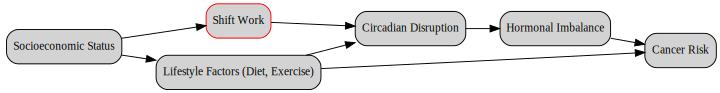

In [13]:
from graphviz import Digraph

# Create a new directed graph
dag = Digraph(format='png')
dag.attr(rankdir='LR', size='10,5')  # Left-to-right orientation with custom size
dag.attr('node', shape='box', style='rounded, filled', fillcolor='lightgrey', fontsize='12')

# Add nodes
dag.node('SES', 'Socioeconomic Status')
dag.node('LF', 'Lifestyle Factors (Diet, Exercise)')
dag.node('SW', 'Shift Work', color = 'red')
dag.node('CD', 'Circadian Disruption')
dag.node('HI', 'Hormonal Imbalance')
dag.node('CR', 'Cancer Risk')

# Add edges to show causal relationships
dag.edge('SES', 'SW')
dag.edge('SES', 'LF')
dag.edge('LF', 'CR')
dag.edge('SW', 'CD')
dag.edge('CD', 'HI')
dag.edge('HI', 'CR')
dag.edge('LF', 'CD')

# Display the DAG
dag.render('shift_work_cancer_dag', view=True)  # Saves as PNG and opens the image
dag


## Question 3

### **Proof of $\mathbb{E}[f(D, X) H] = \mathbb{E}[f(1, X) - f(0, X)]$**

#### **Step 1: Define $H$**

We are given:

$$
H = \frac{D}{p(X)} - \frac{1 - D}{1 - p(X)},
$$

where:
- $D$ is the treatment indicator ($D \in \{0, 1\}$),
- $p(X) = P(D = 1 \mid X)$ is the **propensity score**, the probability of receiving treatment given covariates $X$.

#### **Step 2: Apply the Law of Iterated Expectations**

Using the **law of iterated expectations**, we condition on $X$ first:

$$
\mathbb{E}[f(D, X) H] = \mathbb{E}\left[\mathbb{E}[f(D, X) H \mid X]\right].
$$

#### **Step 3: Compute the Inner Expectation**

Now, we focus on the conditional expectation:

$$
\mathbb{E}[f(D, X) H \mid X] = \mathbb{E}\left[f(D, X) \left(\frac{D}{p(X)} - \frac{1 - D}{1 - p(X)}\right) \Bigg| X \right].
$$

Since $D$ is binary, we expand this as:

$$
= f(1, X) \cdot \mathbb{E}\left[\frac{D}{p(X)} \bigg| X\right] - f(0, X) \cdot \mathbb{E}\left[\frac{1 - D}{1 - p(X)} \bigg| X\right].
$$

#### **Step 4: Simplify the Conditional Expectations**

Using the definitions of **conditional probabilities**:
- $\mathbb{E}[D \mid X] = p(X)$,
- $\mathbb{E}[1 - D \mid X] = 1 - p(X)$,

we find:

1. **For the first term:**

$$
\mathbb{E}\left[\frac{D}{p(X)} \bigg| X\right] = \frac{1}{p(X)} \cdot \mathbb{E}[D \mid X] = \frac{p(X)}{p(X)} = 1.
$$

2. **For the second term:**

$$
\mathbb{E}\left[\frac{1 - D}{1 - p(X)} \bigg| X\right] = \frac{1}{1 - p(X)} \cdot \mathbb{E}[1 - D \mid X] = \frac{1 - p(X)}{1 - p(X)} = 1.
$$

#### **Step 5: Final Simplification**

Substituting back:

$$
\mathbb{E}[f(D, X) H \mid X] = f(1, X) - f(0, X).
$$

Now, take the expectation over $X$:

$$
\mathbb{E}[f(D, X) H] = \mathbb{E}[f(1, X) - f(0, X)].
$$

---

###  **Conclusion**

We've proven:

$$
\mathbb{E}[f(D, X) H] = \mathbb{E}[f(1, X) - f(0, X)],
$$

QED
